In [1]:
import os
import torch
import numpy as np
import torchvision
from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as T
import torch.nn.functional as F

from ig_pkg.datasets import get_datasets

from ig_pkg.models.generator import get_model
from ig_pkg.models.classifier import get_classifier
from ig_pkg.models.pretrained_models import get_pretrained_model

from ig_pkg.inputattribs.ig import make_interpolation, ig
from ig_pkg.inputattribs.baseline_generator import get_baseline_generator

from ig_pkg.misc import process_heatmap, normalize_tensor, convert_to_img, convert_mask_img, label_to_class, tran, na_imshow

import time
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from ig_pkg.loss.focal_loss import FocalLoss
from ig_pkg.loss.metrics import ArcMarginProduct, AddMarginProduct

import torchvision.models as models
from torch.autograd import Variable


IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

my_cmap=plt.cm.seismic(np.arange(plt.cm.seismic.N))


In [2]:
# https://github.com/PAIR-code/saliency/blob/master/Examples_pytorch.ipynb

import saliency.core as saliency

# Boilerplate methods.
def ShowImage(im, title='', ax=None):
    if ax is None:
        plt.figure()
    plt.axis('off')
    plt.imshow(im)
    plt.title(title)

def ShowGrayscaleImage(im, title='', ax=None):
    if ax is None:
        plt.figure()
    plt.axis('off')
    plt.imshow(im, cmap=plt.cm.gray, vmin=0, vmax=1)
    plt.title(title)

def ShowHeatMap(im, title, ax=None):
    if ax is None:
        P.figure()
    P.axis('off')
    P.imshow(im, cmap='inferno')
    P.title(title)

transformer = T.Compose([
    T.Resize(224),
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize(mean = IMAGENET_MEAN, std = IMAGENET_STD),
])

def LoadNumpy(file_path):
    im = Image.open(file_path)
    im = im.resize((224, 224)) # reserve channel 
    im = np.asarray(im)
    return im    

# def PreprocessImages(images):
#     # assumes input is 4-D, with range [0,255]
#     #
#     # torchvision have color channel as first dimension
#     # with normalization relative to mean/std of ImageNet:
#     #    https://pytorch.org/vision/stable/models.html
#     images = np.array(images)
#     images = images/255
#     images = np.transpose(images, (0,3,1,2))
#     images = torch.tensor(images, dtype=torch.float32)
#     images = transformer.forward(images)
#     return images.requires_grad_(True)

def LoadTensor(file_path):
    im = Image.open(file_path)
    temp = np.asarray(im)
#     if len(temp.shape) == 3: images = transformer(im)    
#     else: return None
    
    images = transformer(im)    
    return images.requires_grad_(True)

class_idx_str = 'class_idx_str'
def call_model_function(images, call_model_args=None, expected_keys=None):
    images = PreprocessImages(images)
    target_class_idx =  call_model_args[class_idx_str]
    output = model(images)
    m = torch.nn.Softmax(dim=1)
    output = m(output)
    if saliency.base.INPUT_OUTPUT_GRADIENTS in expected_keys:
        outputs = output[:,target_class_idx]
        grads = torch.autograd.grad(outputs, images, grad_outputs=torch.ones_like(outputs))
        grads = torch.movedim(grads[0], 1, 3)
        gradients = grads.detach().numpy()
        return {saliency.base.INPUT_OUTPUT_GRADIENTS: gradients}
    else:
        one_hot = torch.zeros_like(output)
        one_hot[:,target_class_idx] = 1
        model.zero_grad()
        output.backward(gradient=one_hot, retain_graph=True)
        return conv_layer_outputs

In [3]:
data_path="/root/data/ILSVRC2012_val/"

_, valid_datasets = get_datasets("imagenet1k", data_path)
valid_dataloader = torch.utils.data.DataLoader(valid_datasets, batch_size=1, shuffle=False, num_workers=2)

model = models.resnet18(weights='ResNet18_Weights.DEFAULT')
eval_mode = model.eval()

In [4]:
# n02443484: 40 black-footed_ferret
# n01614925: 398 bald_eagle

data_path="/root/data/ILSVRC2012_val/"

ferrot_dir = os.path.join(data_path, 'val', 'n02443484')
ferrot_idx = os.listdir(ferrot_dir)[1]
ferrot_np = LoadNumpy(os.path.join(ferrot_dir, ferrot_idx))
ferrot_tensor = LoadTensor(os.path.join(ferrot_dir, ferrot_idx))

# eagle_dir = os.path.join(data_path, 'val', 'n01614925')
# eagle_idx = os.listdir(eagle_dir)[1]
# eagle_img = LoadNumpy(os.path.join(eagle_dir, eagle_idx))
# eagle_tensor = LoadTensor(os.path.join(eagle_dir, eagle_idx))


In [10]:
from ig_pkg.metrics import delete_attribution

device = 'cuda:0'
temp = ferrot_tensor.to(device)
baseline = torch.zeros_like(temp)
eval_mode = eval_mode.to(device)

logit_orig = eval_mode(temp.unsqueeze(0))
score_orig = nn.functional.softmax(logit_orig, dim = -1)
init_pred = torch.argmax(logit_orig).item()
prob_orig = score_orig[0, init_pred].item()
# print(prob_orig)

attr = ig(eval_mode, temp, init_pred, baseline, device)
new_tensor = delete_attribution(temp, attr, 5, device)
attr2 = ig(eval_mode, new_tensor, init_pred, baseline, device)

logit_new = model(new_tensor.unsqueeze(0))
score_new = nn.functional.softmax(logit_new, dim = -1)
prob_new = score_new[0, init_pred].item()
print(torch.argmax(logit_new, dim=-1))

tensor([359], device='cuda:0')


In [26]:
def mask_MoRF(x, attr, ratio):
    original_size = x.size() # 3x224x224
    x = x.reshape(3, -1) #3x(224x224)
    attr = torch.tensor(attr).flatten() # (224x224)
    v, index = torch.sort(attr, descending=True, dim=0)    
    index = index[:int(x.size(1)*ratio)]
    x[:, index] = 0.0 
    x = x.reshape(*original_size)
    return x 

def aopc(input, label, attr, model, device, ratio, **kwargs):
        
    logit = model.forward(input.unsqueeze(0))    
    score_orig = nn.functional.softmax(logit, dim = -1)    
    prob_orig = score_orig[0, label].item()
    
    input_hat = mask_MoRF(input.squeeze(0), attr, ratio)
    logit_new = model(input_hat.unsqueeze(0))
    score_new = nn.functional.softmax(logit_new, dim = -1)
    prob_new = score_new[0, label].item()
    
    metric_aopc = prob_orig - prob_new  
    
    return metric_aopc
aopc(ferrot_tensor.to('cuda:0'), 359, attr, eval_mode, device, 0.05,)

/tmp/ipykernel_211317/2806538286.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  attr = torch.tensor(attr).flatten() # (224x224)


0.8561352277174592

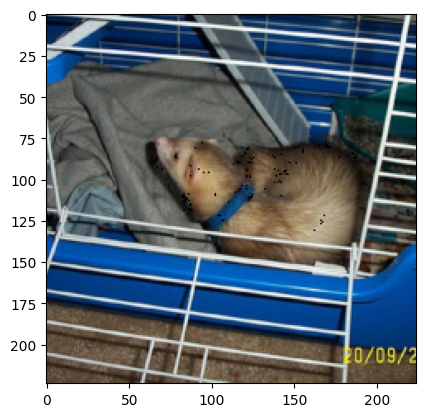

In [11]:
plt.imshow(convert_mask_img(new_tensor))

In [23]:
# def get_rank(attribution, k):
#     flat = attribution.flatten()
#     num = int(attribution.size(-1) * k / 100)
#     val, idx = torch.topk(flat, num)
#     idx_list = [[x.item() // 224, x.item() % 224] for x in idx]
#     return idx_list

# attr.size(-1) * 90 / 100 201
a, b = torch.topk(attr.flatten(), 200)
# a.size()
attr.size()

torch.Size([224, 224])

In [16]:
# a = {}
# name = 1
# a[f'go {name}'] = 0
# a
print(f'{__name__}_{name}')

__main___1


In [39]:
from tqdm import tqdm
idx = []
wrong = []
for i, (inputs, labels) in tqdm(enumerate(valid_dataloader)):
#     print(inputs)
#     print(labels)
    inputs = inputs.to("cuda:0")
    lg = eval_mode(inputs)
    pd = torch.argmax(lg, dim=-1)
#     print(pd)
    if pd.item() == labels.item(): pass
    else: 
        idx.append(i)
        wrong.append(inputs.squeeze(0))


50000it [06:17, 132.31it/s]


In [45]:
# b = []
# for i in range(len(wrong)):
#     temp = wrong[i].clone().detach().cpu()
#     b.append(temp)
c = torch.stack(b)
c.size()

torch.Size([15385, 3, 224, 224])

In [44]:
# np.save('/root/data/results/ig_inversion/idx.npy', idx)
# np.save('/root/data/results/ig_inversion/wrong_18.npy', b)

/root/dh/lib/python3.8/site-packages/numpy/lib/npyio.py:521: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = np.asanyarray(arr)


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (15385,) + inhomogeneous part.

In [ ]:
device = 'cuda:0'
names = {
    'zero',
    'one',
    'min',
    'max',
    'scalar',
#     'encoder',
#     'optimizer',
#     'hybrid',
    'gaussian_blur',
    'gaussian',
    'uniform',
    'maximumdistance' 
}

# {'gaussian',
#  'gaussian_blur',
#  'max',
#  'maximumdistance',
#  'min',
#  'one',
#  'scalar',
#  'uniform',
#  'zero'}

index = 0 
# x,y = valid_datasets[index]
x = ferrot_tensor
y = 359

fig, axes = plt.subplots(2, (len(names)//2)+1, figsize=(2*len(names)//2, 2*2))
axes_flat = axes.flat 
my_cmap=plt.cm.seismic(np.arange(plt.cm.seismic.N))

ax = next(axes_flat)
ax.imshow(convert_to_img(x))

AOPC = []
LODDs = []
Kendal = []
for name in names:
    print(name)
    a = []
    b = []
    try:
        b_generator =  get_baseline_generator(name, scalar = 0.3)
        baseline = b_generator(x=x,y=y)

    except Exception as e: 
        print("-----")
        print("fail:", name)
        print(e)
        continue
        
    attr = ig(eval_mode.to(device), x, y, baseline, device=device)
    Kendal.append(kendal_correlation(eval_mode, ferrot_tensor, baseline, attr.detach().cpu().numpy(), device))

#     print(name)
    for i in range(19):
#         k = i * 5 + 5        
        k = i + 1
        aopc, lodds = pipeline(eval_mode, ferrot_tensor.to(device), baseline, attr, k, device, name)
        
#         print(name, k, aopc, lodds)
        a.append(aopc)
        b.append(lodds)
    
    attr, kwargs  = process_heatmap(attr.cpu(), my_cmap)
    ax = next(axes_flat)
    ax.imshow(attr, **kwargs)
    ax.set_title(name)
    ax.axis("off")
    
    AOPC.append(a)
    LODDs.append(b)    
    
plt.tight_layout()